## Лабораторная работа 1: Алгоритмы разложения матриц. PCA.
_Команда 2_ <br>
_Винниченко, Карцева, Масалимова, Пищулов_
### 1. Метод главных компонент
##### Cингулярное матричные разложения

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.utils.extmath import svd_flip
from sklearn.utils._testing import assert_almost_equal
from sklearn.preprocessing import KernelCenterer

In [2]:
def QR(a):
    b = np.array([np.transpose(a)[0]])
    for i in range(1, len(np.transpose(a))):
        proj_a = 0
        for j in range(len(b)):
            proj_a -= (np.dot(np.transpose(a)
                       [i], b[j])/np.dot(b[j], b[j])) * b[j]
        b_el = np.transpose(a)[i] + proj_a
        b = np.vstack([b, b_el])
    for i in range(len(b)):
        # try:
        print(f"norm: {np.linalg.norm(b[i]), b[i]}")
        b[i] = b[i] / np.linalg.norm(b[i])  # np.sqrt(np.dot(b[i], b[i]))
        # except exception as e:
        #     raise
    Q = -b
    R = np.dot(Q, a)
    return Q.T, R  # Q - собственные вектора, R - собственные значения


In [3]:
def cal_nullspace(A):
    A = A.copy()
    epsilon = 1e-9
    A_shape = A.shape

    for i in range(A_shape[0] - 1):
        if np.abs(A[i, i]) <= epsilon:

            for j in range(i+1, A_shape[0]):
                if np.abs(A[j, i]) > epsilon:

                    A[j, :], A[i, :] = A[i], A[j, :]

        if np.abs(A[i, i]) <= epsilon:

            continue

        for j in range(i+1, A_shape[0]):

            A[j, :] = A[j, :] - 1.0 * A[j, i]/A[i, i] * A[i, :]

    for i in range(A_shape[0]):
        if np.abs(A[i, i]) > epsilon:

            A[i, :] = A[i, :] * (1.0/A[i, i])

    free_eles = np.zeros(A_shape[0], dtype='int')
    cn = 0
    eigv = np.zeros(A_shape[0])
    for i in range(A_shape[0]):
        if np.abs(A[i, i]) < epsilon:
            free_eles[cn] = i
            cn += 1

    if cn == 0:
        return None

    ns = np.zeros((A_shape[0], cn))

    for i in range(cn):
        ns[free_eles[i], i] = 1
        for j in range(A_shape[0] - 1, -1, -1):
            if np.abs(A[j, j]) > epsilon:
                ns[j, i] = 0 - np.dot(A[j, j+1:], ns[j+1:, i])

    if cn >= 2:
        q, r = QR(ns)
        ns = q
    else:
        sq = np.sqrt(np.dot(ns[:, 0], ns[:, 0]))
        ns /= sq

    return ns


In [4]:
def eigen_qr_simple(A):
    Ak = np.copy(A)
    e = 1e-9
    t = 0
    while True:
        Q, R = QR(Ak)
        Ak = R @ Q
        t = 0
        for i in range(1, A.shape[1]):
            for j in range(0, i):
                t += np.abs(Ak[i, j])
        if t <= e:
            break
    return np.diag(Ak)


In [5]:
def eig(A):
    eig_vals = np.sort(eigen_qr_simple(A))[::-1]
    A_shape = A.shape
    eig_vectors = np.zeros((A.shape[0], A.shape[0]))
    preval = None
    curid = 0
    for eigval in eig_vals:
        if preval == eigval:
            continue
        A_eig = A - np.eye(A_shape[0]) * eigval  # характеристическая матрица
        cur_vectors = cal_nullspace(A_eig)
        preval = eigval

        for i in range(cur_vectors.shape[1]):
            eig_vectors[:, curid] = cur_vectors[:, i]
            curid += 1

    return (eig_vals, eig_vectors)


In [6]:
# np.linalg.eig(centred_data.T@centred_data)


In [7]:
# eigen_qr_simple(centred_data.T@centred_data)


In [8]:
toy = np.array([[0.45, 1.72],
                [1.28, 0.92]])

u, s, vh = np.linalg.svd(toy)
u, vh


(array([[-0.7598468 , -0.65010217],
        [-0.65010217,  0.7598468 ]]),
 array([[-0.5246598 , -0.85131198],
        [ 0.85131198, -0.5246598 ]]))

In [9]:
svd_flip(u, vh)


(array([[ 0.7598468 , -0.65010217],
        [ 0.65010217,  0.7598468 ]]),
 array([[ 0.5246598 ,  0.85131198],
        [ 0.85131198, -0.5246598 ]]))

In [10]:
# rs = np.random.RandomState(1999)
# n_samples = 20
# n_features = 10
# X = rs.randn(n_samples, n_features)

# # Check matrix reconstruction
# U, S, V = np.linalg.svd(X, full_matrices=False)
# U1, V1 = svd_flip(U, V, u_based_decision=False)
# # assert_almost_equal(np.dot(U1 * S, V1), X, decimal=6)


In [11]:
# u, s, vh = svd_SP(toy)
# restored = u@s@vh
# assert_almost_equal(restored, toy, decimal=6)
# u.shape, s.shape, vh.shape


In [12]:
# u, s , vh


In [13]:
# U, S, V = np.linalg.svd(toy, full_matrices=False)
# U2, V2 = svd_flip(U, V, u_based_decision=True)
# U2, S, V2


In [14]:
def get_eig(x):
    eigenValues, eigenVectors = np.linalg.eig(x)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenValues, eigenVectors


def svd_SP(x):
    left_sigmas_squared, left_sing_vecs = get_eig(x@x.T)  # u
    right_sigmas_squared, right_sing_vecs = get_eig(x.T@x)  # v
    sigmas_squared = min (left_sigmas_squared, right_sigmas_squared, key=len)
    sing_vals = np.array([np.sqrt(eig_val) for eig_val in sigmas_squared])#!!!
    
    # left_sing_vecs, s, right_sing_vecs = np.linalg.svd(x)
    # u, vh = svd_flip(left_sing_vecs.astype('float64'), right_sing_vecs.astype('float64'))
    V = right_sing_vecs.T
    U = left_sing_vecs
    # U, S, V = np.linalg.svd(x, full_matrices=False)
    U1, V1 = U, V  # svd_flip(U.astype('float64'), V.astype('float64'))
    sigma = np.zeros(x.shape)
    min_dim = len(sigmas_squared)
    sigma[:min_dim, :min_dim] = np.diag(sing_vals)
    restored = (U1@sigma)@V1
    if np.sign(restored[0][0])*np.sign(x[0][0]) < 0:  # cringe
        # U1[:, :min_dim] *= -1
        V1 = -1*V1
    return U1, sigma, V1


def svd(A, retSimple=False):
    # sing_vals = np.array([np.sqrt(eig_val)
    #                      for eig_val in eig(A@A.T)[0]])
    # left_sing_vecs = eig(A@A.T)[1]  # u
    right_sing_vecs = eig(A.T@A)[1]  # v
    # return left_sing_vecs, sing_vals, right_sing_vecs.T
    epsilon = 1e-4
    A_shape = A.shape

    e, v = eig(A.T @ A)
    e_sqrt = np.sqrt(np.take(e, np.where(e > epsilon)[0]))
    r = len(e_sqrt)

    U = np.zeros((A_shape[0], A_shape[0]))  # m*m
    S = np.zeros(A_shape)  # m*n
    S[:r, :r] = np.diag(e_sqrt)
    V = np.zeros((A_shape[1], A_shape[1]))  # n*n
    V[:, :r] = v
    print(A.shape, V.shape, S.shape)
    # U = A@V@S.T
    # return U, S, V.T

    for i in range(r):
        ui = np.dot(A, v[:, i])
        ui = ui / np.sqrt(np.dot(ui, ui))
        U[:, i] = ui

    if retSimple:
        U = U[:, :r]
        S = S[:r, :r]
        V = v[:, :r].T
    else:
        if r < A_shape[0]:
            ns = cal_nullspace(U.T)
            U[:, r:] = ns
        V = v.T

    return (U, S, V)


##### Представление набора данных

Source: World Bank Government Indicators  (Kaufmann et al. 2016)

e_wbgi_vae -- voice and accountability (показатель, измеряющий различные аспекты
политического процесса, гражданских свобод и политических прав)

e_wbgi_cce -- control of corruption (показатель восприятия коррупции, традиционно определяемой
как осуществление публичной власти ради частной выгоды)

e_wbgi_gee -- government effectiveness (показатель качества
предоставления государственных услуг, качество бюрократии, компетентность государственных служащих,
независимость государственной службы от политического давления и доверие к правительству

e_wbgi_rle -- rule of law (показатель успеха общества в развитии среды, в
которой справедливые и предсказуемые правила составляют основу экономических и социальных взаимодействий и
в которой права собственности защищены)

e_wbgi_rqe -- regulatory quality (показатель распространенности недружественной к рынку политики
такие как контроль над ценами или неадекватный банковский надзор, а также восприятие бремени
вызванное чрезмерным регулированием в таких областях, как внешняя торговля и развитие бизнеса)

Time period: 1996-2021 (exluding 1997, 1999, 2001)

Sample: 15 post-Soviet countries

In [15]:
# import data
dataframe1 = pd.read_excel("data_lab1.xlsx")
# print(dataframe1)
features = ['e_wbgi_vae', 'e_wbgi_cce',
            'e_wbgi_gee', 'e_wbgi_rle', 'e_wbgi_rqe']
df1 = dataframe1.loc[:, features].values

# mean centering
mean_values = np.mean(df1, axis=0)
centred_data = df1 - mean_values
# print(centred_data)


##### Применение метода сингулярного разложения на данных

In [16]:
from collections import defaultdict


def get_pca(x):
    centered = x - x.mean(axis=0)
    n, m = centered.shape
    y = centered/np.sqrt(n-1)
    _, sigma, vh = svd_SP(y)  # np.linalg.svd(y)  #svd(y)#
    disps = np.diag(sigma).copy()
    # disps /=sum(disps)
    # print(f'sigma: {sigma}')
    # c = y.T@y
    pr_components = vh.T
    return pr_components


def get_kernel_pca(k, n_components):
    eig_vals, eig_vecs = np.linalg.eig(k)
    pr_components = eig_vecs[:, :n_components]
    return eig_vals[:n_components], pr_components  


X = centred_data
pcs = get_pca(X)
t = X[0]  # first object
sum_distances_by_pc = defaultdict(int)
for pc_num, pc in enumerate(pcs.T):
    for obj in X:
        projection = pc@obj
        sum_distances_by_pc[pc_num] += projection**2

vars = pd.Series(sum_distances_by_pc, index=sorted(
    list(sum_distances_by_pc.keys())))
vars /= sum(vars)
vars


0    0.913561
1    0.045756
2    0.024779
3    0.009996
4    0.005907
dtype: float64

In [17]:
selected_pcs = pcs[:, :2]
transformed = X@selected_pcs
transformed.shape


(345, 2)

[0.91356135 0.04575646]


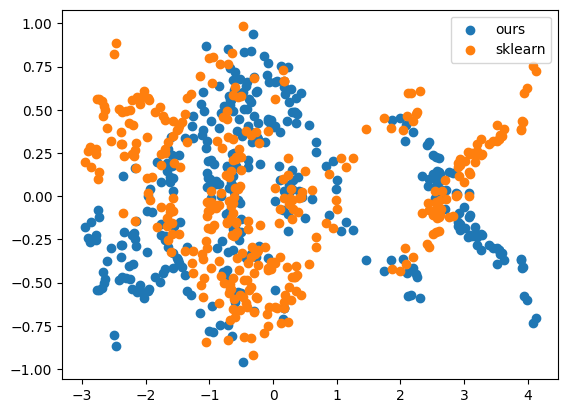

In [18]:
sk_pca = PCA(n_components=2)

sk_pca.fit(X)
print(sk_pca.explained_variance_ratio_)

sk_transformed = sk_pca.transform(X)
plt.scatter(x=transformed[:, 0], y=transformed[:, 1])
plt.scatter(x=sk_transformed[:, 0], y=sk_transformed[:, 1]+0.02)
plt.legend(['ours', 'sklearn'])


##### Преимущества и недостатки применения сингулярного и спектрального разложения к задачам PCA

In [19]:
# V.T


In [20]:
explained_variances = vars  # np.diag((S ** 2) / (len(centred_data) - 1))
# explained_variances


##### Определение числа компонент, визуализация данных, анализ полученных компонент

In [21]:
cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_ratio = cumulative_explained_variance / \
    np.sum(explained_variances)


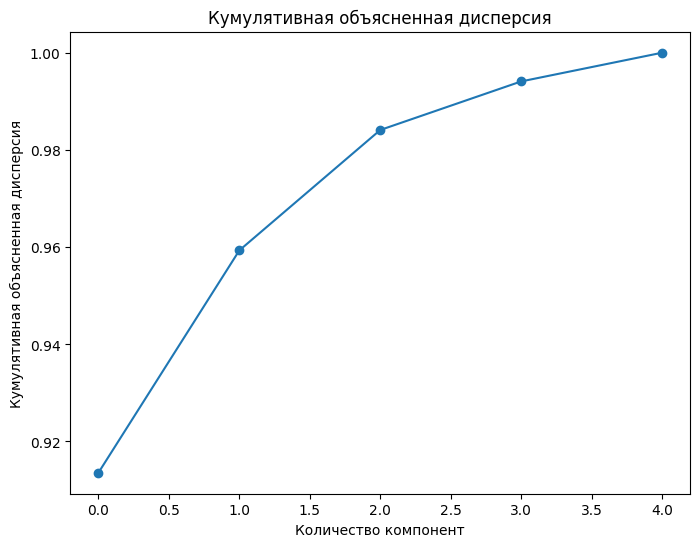

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Кумулятивная объясненная дисперсия')
plt.show()


In [23]:
# num_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1

# # Шаг 3: Визуализация данных в новом пространстве компонент
# PC_matrix_selected = PC_matrix[:, :num_components]
# transformed_data = np.dot(X, PC_matrix_selected)


##### Дополнительное задание

### 2. Kernel PCA

##### Представление набора данных

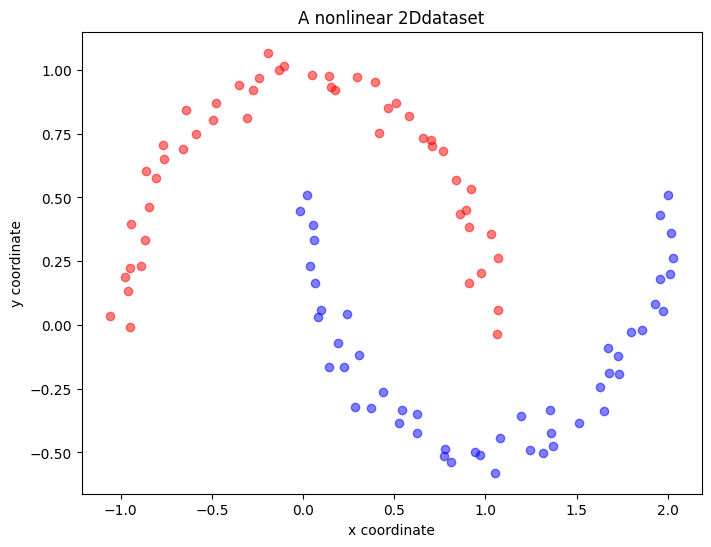

In [24]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123, noise=0.05)#.05)
moons_x, moons_y = X, y
plt.figure(figsize=(8, 6))

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()


In [25]:
# moons = np.concatenate([X, y.reshape((-1, 1))], axis=1)
mean_values = np.mean(moons_x, axis=0)
centred_data = moons_x - mean_values
moons_x = centred_data


#### Попробуем PCA

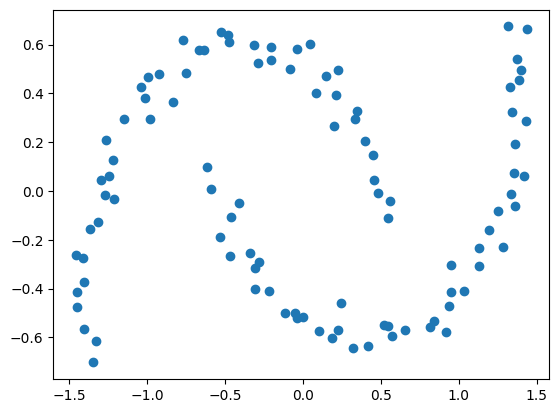

In [26]:
X = centred_data
pcs = get_pca(X)
t = X[0]  # first object
sum_distances_by_pc = defaultdict(int)
for pc_num, pc in enumerate(pcs.T):
    for obj in X:
        projection = pc@obj
        sum_distances_by_pc[pc_num] += projection**2


selected_pcs = pcs[:, :2]
transformed = X@selected_pcs
plt.scatter(x=transformed[:, 0], y=transformed[:, 1])

##### Вывод: PCA не справился с линейным разделением

##### Реализация методов вычисления матрицы для различных ядер  и её последующего спектрального разложения

In [27]:
# def get_poly_features(x):
#     return np.concatenate([x]+[(x[:, feature]**power).reshape((-1, 1)) for power in (2, 3) for feature in range(x.shape[1])], axis=1)
# get_poly_features(moons).shape


def get_poly_kernel(x, c0, degree):  # relationship between columns
    feature_cnt = x.shape[1]
    ker = np.zeros((feature_cnt, feature_cnt))
    for f1 in range(feature_cnt):
        for f2 in range(f1, feature_cnt):
            ker[f1, f2] = (x[:, f1]@x[:, f2]+c0)**degree
            ker[f2, f1] = ker[f1, f2]
    return ker


def get_tanh_kernel(x, c0):
    feature_cnt = x.shape[1]
    ker = np.zeros((feature_cnt, feature_cnt))
    for f1 in range(feature_cnt):
        for f2 in range(f1, feature_cnt):
            ker[f1, f2] = np.tanh(x[:, f1]@x[:, f2]+c0)
            ker[f2, f1] = ker[f1, f2]
    return ker


def get_rbf_kernel(x, gamma):
    feature_cnt = x.shape[1]
    ker = np.zeros((feature_cnt, feature_cnt))
    for f1 in range(feature_cnt):
        for f2 in range(f1, feature_cnt):
            # print(x[:, f1]-x[:, f2])
            ker[f1, f2] = np.exp(-gamma*np.linalg.norm(x[:, f1]-x[:, f2])**2)
            ker[f2, f1] = ker[f1, f2]
    return ker

# get_poly_kernel(moons)


In [28]:
# t = moons_x.T
# x=t
# f1=0
# f2=1
# np.exp(-0.2*np.linalg.norm(x[:, f1]-x[:, f2])**2)

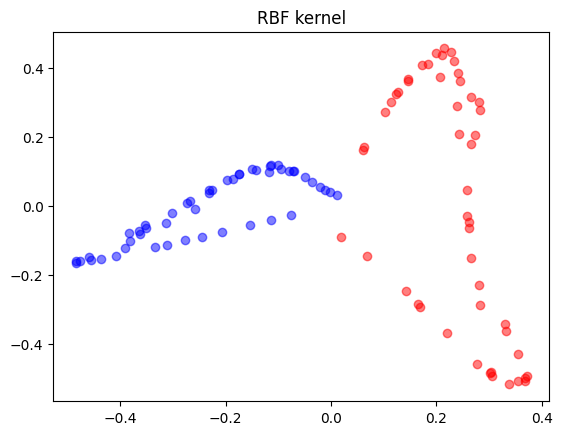

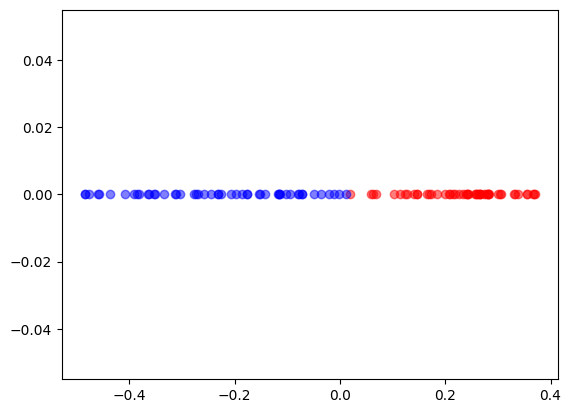

In [29]:
K = get_rbf_kernel(moons_x.T, gamma=15)
Kc = KernelCenterer().fit_transform(K)
K = Kc
eig_vals, pcs = get_kernel_pca(K, n_components=2)
transformed = K@pcs@np.diag((np.abs(eig_vals)**(-1/2)))# abs?
red_moon = transformed[moons_y == 0, :]
blue_moon = transformed[moons_y == 1, :]
plt.scatter(x=red_moon[:, 0], y=red_moon[:, 1], color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=blue_moon[:, 1], color='blue', alpha=0.5)
plt.title("RBF kernel")
plt.show()

plt.scatter(x=red_moon[:, 0], y=np.zeros_like(red_moon[:, 0]), color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=np.zeros_like(blue_moon[:, 0]), color='blue', alpha=0.5)


/home/serhio/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


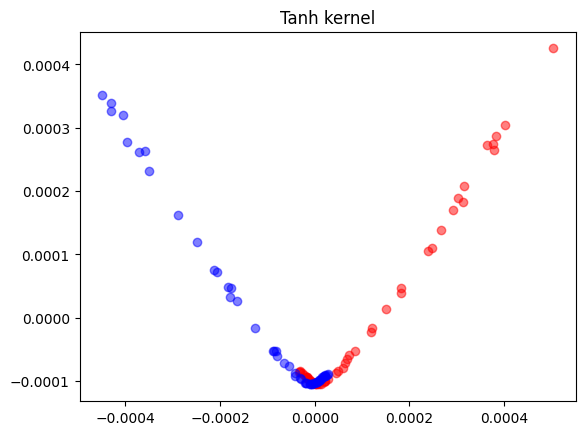

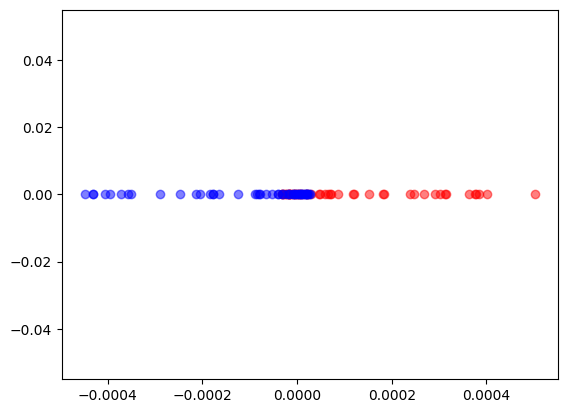

In [30]:
K = get_tanh_kernel(moons_x.T, c0=10)
Kc = KernelCenterer().fit_transform(K)
K = Kc
eig_vals, pcs = get_kernel_pca(K, n_components=2)
transformed = K@pcs@np.diag((np.abs(eig_vals)**(-1/2)))# abs?
red_moon = transformed[moons_y == 0, :]
blue_moon = transformed[moons_y == 1, :]
plt.scatter(x=red_moon[:, 0], y=red_moon[:, 1], color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=blue_moon[:, 1], color='blue', alpha=0.5)
plt.title("Tanh kernel")
plt.show()

plt.scatter(x=red_moon[:, 0], y=np.zeros_like(red_moon[:, 0]), color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=np.zeros_like(blue_moon[:, 0]), color='blue', alpha=0.5)


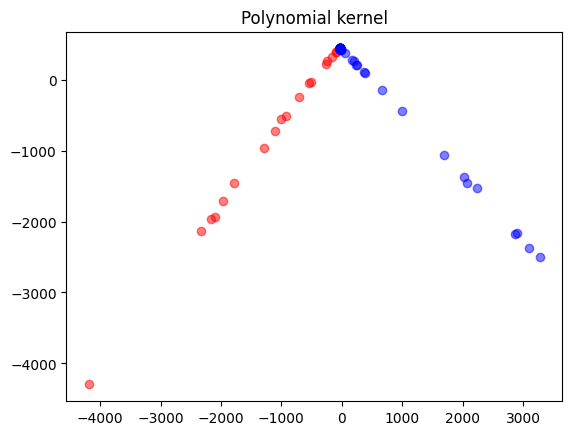

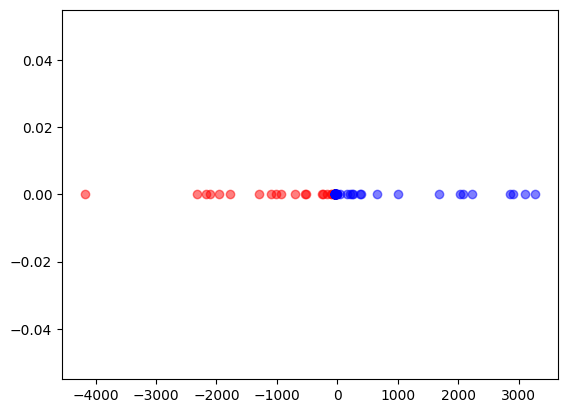

In [31]:
K = get_poly_kernel(moons_x.T, c0=1, degree=14)
Kc = KernelCenterer().fit_transform(K)
K = Kc
eig_vals, pcs = get_kernel_pca(K, n_components=2)
transformed = K@pcs@np.diag((np.abs(eig_vals)**(-1/2)))# abs?
red_moon = transformed[moons_y == 0, :]
blue_moon = transformed[moons_y == 1, :]
plt.scatter(x=red_moon[:, 0], y=red_moon[:, 1], color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=blue_moon[:, 1], color='blue', alpha=0.5)
plt.title("Polynomial kernel")

plt.show()

plt.scatter(x=red_moon[:, 0], y=np.zeros_like(red_moon[:, 0]), color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=np.zeros_like(blue_moon[:, 0]), color='blue', alpha=0.5)


Text(0.5, 1.0, 'Sklearn')

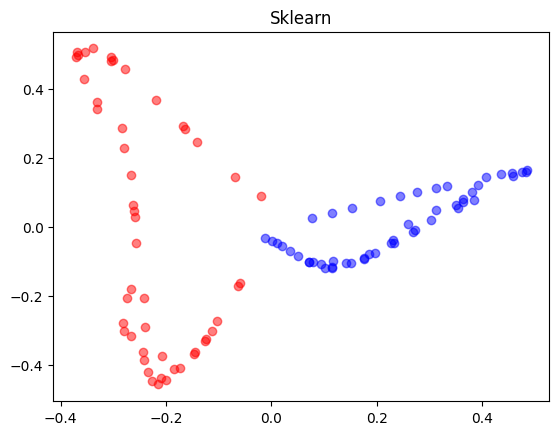

In [32]:
from sklearn.decomposition import KernelPCA

# sk_pca = KernelPCA(n_components=2, kernel='rbf', degree=2, coef0=1, gamma=1)
sk_pca = KernelPCA(n_components=2, kernel='rbf', gamma=15)

sk_pca.fit(moons_x)
# print(sk_pca.explained_variance_ratio_)

sk_transformed = sk_pca.transform(moons_x)
red_moon = sk_transformed[moons_y == 0, :]
blue_moon = sk_transformed[moons_y == 1, :]
plt.scatter(x=red_moon[:, 0], y=red_moon[:, 1], color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=blue_moon[:, 1], color='blue', alpha=0.5)
plt.title("Sklearn")
# plt.scatter(x=sk_transformed[:, 0], y=sk_transformed[:, 1]+0.2)


##### Сравнительный анализ применения PCA и Kernel PCA